#### import requried libraries

In [14]:
from ml_toolkit import encode_str_columns, write_excel_sheet_v2

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F

import datetime

#### read the data cleaned in EDA (eda.ipynb)

In [15]:
output_column = 'Suicide'
data = pd.read_csv( r"output\data\data_filtered_imputed_clean.csv", dtype = 'category' )

#### filter the data for Suicides and natural deaths

In [16]:
data = data.loc[ data[ output_column ].isin( [ '1', '0' ] ) ]
data.drop( columns = [ 'Follow', 'Povpct' ], inplace = True, errors = 'ignore' )

#### one-hot encode the data, and transform into tensors for training and test set

In [17]:
# prepare data
factorization_technique = 'one-hot'
data_ = encode_str_columns( data.astype( str ), technique = factorization_technique, str_attributes = None, max_unique_values_allowed_for_str = None, drop_extras = False, output_column = output_column )
"""scaler = StandardScaler()
data_[ number_cols ] = scaler.fit_transform( data_[ number_cols ] )"""

for x in data_.columns:
    # data_[ x ] = pd.to_numeric( data_[x] )
    data_[ x ] = data_[x].astype( int )

X_train, X_test, y_train, y_test = train_test_split( data_.drop( columns = [output_column] ), data_[ output_column ], test_size = 0.25, random_state = 42, stratify = data_[ output_column ] )

X_train = torch.tensor( np.stack( X_train.values, axis = 0 ), dtype = torch.float )
X_test = torch.tensor( np.stack( X_test.values, axis = 0 ), dtype = torch.float )
y_train = torch.tensor( np.stack( y_train.values, axis = 0 ), dtype = torch.long )
y_test = torch.tensor( np.stack( y_test.values, axis = 0 ), dtype = torch.long )

string columns found: ['Race', 'Sex', 'Ms', 'Hisp', 'Adjinc', 'Educ', 'Hhnum', 'Reltrf', 'Majocc', 'Majind', 'Esr', 'Urban', 'Smsast', 'Ssnyn', 'Vt', 'Histatus', 'Hitype', 'Tenure', 'Working', 'Age', 'Pob', 'Stater']
encoding Sex, Urban, Ssnyn, Vt, Histatus, Working, Hisp, Smsast, Tenure, Race, Ms, Esr, Reltrf, Hitype, Age, Stater, Majocc, Hhnum, Pob, Adjinc, Educ, Majind using one-hot
time taken to create dummy variables: 0.1740 secs


#### one common utility method for fetching the pytorch model

In [18]:
"""
    build the pytorch model as requested out of three options
    input_features - the number of independent variables
    hidden_1_features - the number of hidden features at level 1
    hidden_2_features - the number of hidden features at level 2
    output_features - the number of classes to be predicted for the dependent variable
    epochs - the number of iterations to train the model
    model_choice - the choice of model to be built using the method
"""
def get_model( input_features, hidden_1_features, hidden_2_features, output_features, epochs = 200, model_choice = 'one' ):
    print( "fetching NN model for '{0}', epoch = '{1}', model = '{2}'".format( ( input_features, hidden_1_features, hidden_2_features, output_features ), epochs, model_choice ) )
    nn_model = None
    torch.manual_seed( 42 )

    if model_choice == "one":
        # create model
        class Model( nn.Module ):
            def __init__( self, input_features, hidden_1, hidden_2, output_features = 2 ):
                super().__init__()
                self.f_connected_1 = nn.Linear( input_features, hidden_1 )
                self.f_connected_2 = nn.Linear( hidden_1, hidden_2 )
                self.out = nn.Linear( hidden_2, output_features )
                self.batchnorm_1 = nn.BatchNorm1d( hidden_1 )
                self.batchnorm_2 = nn.BatchNorm1d( hidden_2 )
                self.dropout = nn.Dropout( p = 0.2 )

            def forward( self, x ):
                x = F.relu( self.f_connected_1( x ) )
                x = self.batchnorm_1( x )
                x = F.relu( self.f_connected_2( x ) )
                x = self.batchnorm_2( x )
                x = self.dropout( x )
                x = self.out( x )
                x = torch.softmax( x, dim = 1 )
                return x

        nn_model = Model( input_features, hidden_1_features, hidden_2_features, output_features )
    elif model_choice == "two":
        class NN_Classifier( torch.nn.Module ):
            def __init__(self, input_features, hidden_1_features, hidden_2_features, output_features ):
                # Define layers
                super(NN_Classifier, self).__init__()
                self.fc1 = torch.nn.Linear(input_features, hidden_1_features)
                self.bn1 = torch.nn.BatchNorm1d(hidden_1_features)
                self.fc2 = torch.nn.Linear(hidden_1_features, hidden_2_features)
                self.bn2 = torch.nn.BatchNorm1d(hidden_2_features)
                self.fc3 = torch.nn.Linear(hidden_2_features, output_features)

            def forward(self, x):
                # Define sequence of layers
                x = self.fc1(x) # Fully connected layer
                x = self.bn1(x) # Batch normalisation
                x = F.dropout(x, p = 0.35 ) # Apply dropout
                x = F.relu(x) # ReLU activation
                x = self.fc2(x)
                x = self.bn2(x)
                x = F.dropout(x, p = 0.35 )
                x = F.relu(x)
                x = self.fc3(x)
                x = torch.sigmoid(x) # Sigmoid output (0-1)
                return x
        nn_model = NN_Classifier( input_features, hidden_1_features, hidden_2_features, output_features )
    elif model_choice == 'three':
        nn_model = torch.nn.Sequential(
            nn.Linear( input_features, hidden_1_features ),
            nn.ReLU(),
            nn.Linear( hidden_1_features, hidden_2_features),
            nn.ReLU(),
            nn.Linear( hidden_2_features, output_features ),
            nn.LogSoftmax( dim = 1 )
        )
    return nn_model

In [19]:
# backward propagation - define loss function, and the optimizer
def get_loss_fn_optimizer( nn_model, model_choice ):
    if model_choice in [ "three" ]:
        # using Stochastic Gradient Descent as optimizer for the model design which uses log_soft_max for the activation functionn
        loss_fn = nn.NLLLoss()
        optimizer = torch.optim.SGD( nn_model.parameters(), lr = 0.01 )
    else:
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam( nn_model.parameters(), lr = 0.01 )
    return loss_fn, optimizer

In [20]:
def compute_losses( nn_model, epochs, X_train, y_train ):
    print( "\n computing losses. . ." )
    final_losses = []
    for epoch in range( epochs ):
        epoch += 1
        y_pred = nn_model.forward( X_train )
        loss = loss_fn( y_pred, y_train )
        final_losses.append( loss )
        if epoch % 25 == 0:
            print( "Epoch# {0}, loss: {1}".format( epoch, loss.item() ) )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return final_losses

In [21]:
# map the loss function
import matplotlib.pyplot as plt
# %matplotlib inline
def plot_loss_function( epochs, final_losses, model_choice ):
    plt.plot( range( epochs ), final_losses )
    plt.ylabel( 'Loss' )
    plt.xlabel( 'Epoch' )
    plt.title( model_choice )
    

In [22]:
""" fetch predictions for the test data using model of choice """
def get_predictions( X_test, nn_model, model_choice ):
    predictions = []
    with torch.no_grad():
        predictions = nn_model( X_test )
    if model_choice in [ "three" ]:
        predictions = [ torch.exp( x ).argmax().item() for x in predictions ]
    else:
        predictions = [ x.argmax().item() for x in predictions ]
    print( pd.Series( predictions ).value_counts() )
    return predictions

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
"""
    plot the confusion matrix
"""
def plot_cm( y_test, predictions, model_choice ):
    cm = confusion_matrix( y_test, predictions )
    plt.figure( figsize = ( 10, 6 ) )
    sns.heatmap( cm, annot = True )
    plt.xlabel( "Actual" )
    plt.ylabel( "Prediction" )
    plt.title( model_choice )
    

In [24]:
model_choices = [ "one", "two", "three" ]
accuracy_scores = {}

#### initialize attributes for the features to input, hidden and the output layer

In [25]:
epochs = 500
# instantiate the model
input_features = X_train.shape[ 1 ]
hidden_1_features = 64
hidden_2_features = 64
output_features = np.unique( y_test ).shape[ 0 ]

#### build model, compute losses, collate predictions, and accuracy

In [36]:
final_losses = {}
predictions = {}
accuracy_scores = {}
nn_model = {}
for model_choice in model_choices:
    print("\n\n================================================================================================\n\n")
    nn_model[ model_choice ] = get_model( input_features, hidden_1_features, hidden_2_features, output_features, epochs, model_choice )
    loss_fn, optimizer = get_loss_fn_optimizer( nn_model[ model_choice ], model_choice )
    final_losses[ model_choice ] = compute_losses( nn_model[ model_choice ], epochs, X_train, y_train )
    
    # plot_loss_function( epochs, final_losses )
    predictions[ model_choice ] = get_predictions( X_test, nn_model[ model_choice ], model_choice )

    # plot_cm( y_test, predictions )
    accuracy_scores[ model_choice ] = accuracy_score( y_test, predictions[ model_choice ] )
    
    # Set up lists to hold results
    if "training_acc_results" not in locals():
        training_acc_results = []
        test_acc_results = []

    with torch.no_grad():
        tmp_predictions = nn_model[ model_choice ]( X_train )
        tmp_predictions = [ x.argmax().item() for x in tmp_predictions ]
    training_acc_results.append( np.mean( pd.Series( tmp_predictions ) == pd.Series( y_train ) ) )
    tmp_predictions = None
    with torch.no_grad():
        tmp_predictions = nn_model[ model_choice ]( X_test )
        tmp_predictions = [ x.argmax().item() for x in tmp_predictions ]
    test_acc_results.append( np.mean( pd.Series( tmp_predictions ) == pd.Series( y_test ) ) )
    tmp_predictions = None
    print("\n\n================================================================================================\n\n")





fetching NN model for '(144, 64, 64, 2, 500, 'one')'

 computing losses. . .
Epoch# 25, loss: 0.4030534625053406
Epoch# 50, loss: 0.3745913505554199
Epoch# 75, loss: 0.3704220652580261
Epoch# 100, loss: 0.37018725275993347
Epoch# 125, loss: 0.3701980710029602
Epoch# 150, loss: 0.3704874515533447
Epoch# 175, loss: 0.368665874004364
Epoch# 200, loss: 0.36616429686546326
Epoch# 225, loss: 0.3653024137020111
Epoch# 250, loss: 0.3644236922264099
Epoch# 275, loss: 0.36448195576667786
Epoch# 300, loss: 0.36413800716400146
Epoch# 325, loss: 0.36424240469932556
Epoch# 350, loss: 0.3633890748023987
Epoch# 375, loss: 0.3623735308647156
Epoch# 400, loss: 0.36122897267341614
Epoch# 425, loss: 0.36150074005126953
Epoch# 450, loss: 0.3613640367984772
Epoch# 475, loss: 0.36107394099235535
Epoch# 500, loss: 0.3606874346733093
1    553
0    532
dtype: int64








fetching NN model for '(144, 64, 64, 2, 500, 'two')'

 computing losses. . .
Epoch# 25, loss: 0.5244485139846802
Epoch# 50, loss: 0.4770

#### lets look at the behavior of losss function in all 3 models

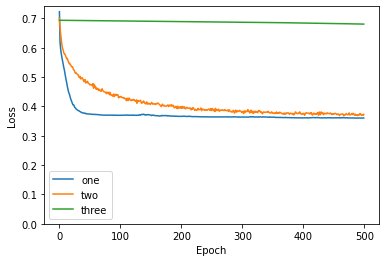

In [38]:
for model_choice in model_choices:
    plt.plot( range( epochs ), final_losses[ model_choice ] )

plt.ylabel( 'Loss' )
plt.xlabel( 'Epoch' )
plt.ylim( bottom = 0 )
plt.legend( model_choices )

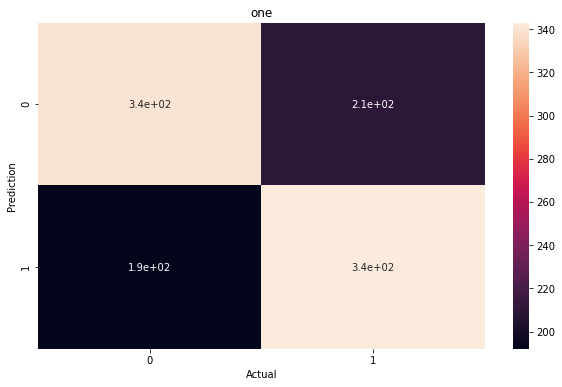

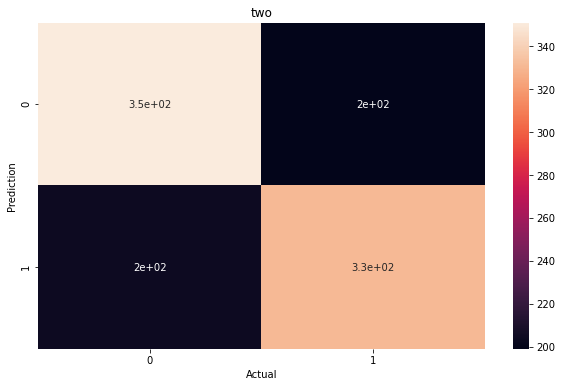

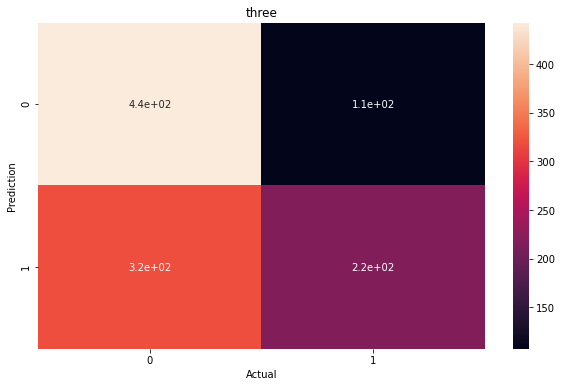

In [39]:
for model_choice in model_choices:
    plot_cm( y_test, predictions[ model_choice ] , model_choice )

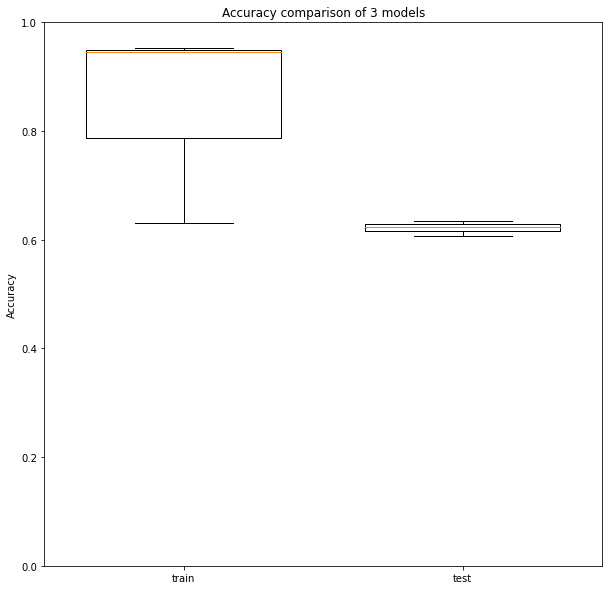

In [30]:
x_for_box = [ training_acc_results, test_acc_results ]
labels = [ "train", "test" ]
fig = plt.figure( figsize = (10, 10) )
ax1 = fig.add_subplot( 111 )
ax1.boxplot( x_for_box, widths = 0.7 )
ax1.set_xticklabels( labels )
ax1.set_ylabel( "Accuracy" )
ax1.set_ylim( bottom = 0, top = 1 )
ax1.set_title( "Accuracy comparison of 3 models" )
plt.show()

In [31]:
accuracy_nn = pd.DataFrame.from_dict( dict( 
        zip(
        model_choices,
            dict(
                zip(
                    training_acc_results, test_acc_results
                    )
        ).items()
        )
    )
)

Text(0.5, 1.0, 'Accuracy')

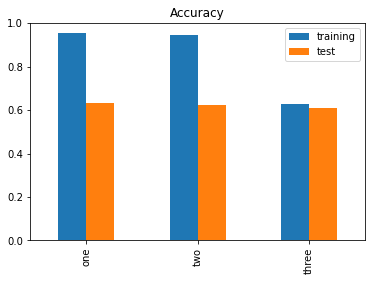

In [32]:
accuracy_nn = accuracy_nn.T
accuracy_nn.columns= [ "training", "test" ]
plt_ = accuracy_nn.plot( kind = 'bar' )
plt_.set_title( "Accuracy" )

In [41]:
write_excel_sheet_v2( accuracy_nn, "output/accuracy/nn_pytorch.xlsx" )

finally writing .xlsx file: 'nn_pytorch.xlsx'


WindowsPath('output/accuracy/nn_pytorch.xlsx')

In [42]:
accuracies = pd.read_excel( "data_/accuracies.xlsx" )

Text(0.5, 1.0, 'Classification Models')

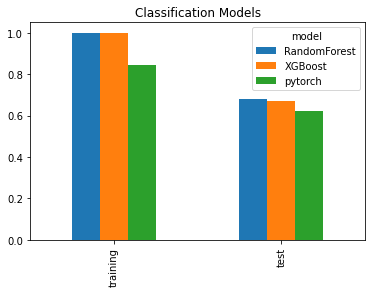

In [44]:
accuracies.groupby( 'model' ).mean().T.plot( kind = 'bar' ).set_title( "Classification Models" )